<a href="https://colab.research.google.com/github/dhcryan/kaggle_challenge_/blob/main/donghun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Store Sales - Time Series Forecasting**

 * For grocery stores, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction.

 * you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -qq '/content/drive/MyDrive/store-sales-time-series-forecasting.zip'

replace holidays_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [42]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from xgboost import XGBClassifier
from xgboost import  XGBRegressor

cpu


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import seaborn as sns
import calendar
import datetime

In [6]:
path='/content/'

### Read data

In [46]:
df_holidays = pd.read_csv(path+'holidays_events.csv')
df_oil = pd.read_csv(path+'oil.csv')
df_stores = pd.read_csv(path+'stores.csv')
df_trans = pd.read_csv(path+'transactions.csv')

In [47]:
train=pd.read_csv(path+'train.csv')
test=pd.read_csv(path+'test.csv')

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


df_stores 말고는 date 데이터가 있는데 object로 되어 있으니 시계열로 표현하기 위해서 datetime으로 변경

In [49]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
train['date'] = pd.to_datetime(train['date'], format = "%Y-%m-%d")
test['date'] = pd.to_datetime(test['date'], format = "%Y-%m-%d")

In [50]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [51]:
df_holidays['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

- Additional : 추가적인 휴일

- Daily oil price. Includes values during both the train and test data timeframes

dcoilwtico가 oil price이니 이름을 바꿔보자

In [52]:
df_oil.rename(columns={'dcoilwtico':'oilprice'},inplace=True)

In [53]:
df_oil.head()

,date,oilprice
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [54]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [55]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [56]:
df_stores.type.value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

In [57]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [58]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### train data 분석

In [59]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0




*   `store_nbr` : the store at which the products are sold.
*   `family` : the type of product sold.
*   `sales` : total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
*   `onpromotion` : total number of items in a product family that were being promoted at a store at a given date.



In [60]:
train['sales'].nunique()
train['date'].nunique() #1684

1684

In [22]:
train['onpromotion'].nunique() #362

362

In [23]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           3000888 non-null  int64         
 1   date         3000888 non-null  datetime64[ns]
 2   store_nbr    3000888 non-null  int64         
 3   family       3000888 non-null  object        
 4   sales        3000888 non-null  float64       
 5   onpromotion  3000888 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [24]:
train.isna().mean()

id             0.0
date           0.0
store_nbr      0.0
family         0.0
sales          0.0
onpromotion    0.0
dtype: float64

Let's merge oil data into the train and test data

In [61]:
train=train.merge(df_oil,on='date')
test=test.merge(df_oil,on='date')

In [62]:
train=train.merge(df_holidays[['date','type','transferred']],on='date')
train=train.merge(df_stores,on='store_nbr')

In [27]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,oilprice,type_x,transferred,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,False,Quito,Pichincha,D,13


stores에도 type이 있고 holiday에도 type이 있어 이름 바꿔줘야 함

In [63]:
train.rename(columns={'type_x':'holiday_type','type_y':'store_type'},inplace=True)

In [64]:
train['year']=train.date.dt.year
train['year-month']=train['date'].apply(lambda x:x.strftime('%Y-%m'))
train['month']=train.date.dt.month
train['day']=train.date.dt.day
train

,id,date,store_nbr,family,sales,onpromotion,oilprice,holiday_type,transferred,city,state,store_type,cluster,year,year-month,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
4,4,2013-01-01,1,BOOKS,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352831,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15
352832,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15
352833,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15
352834,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15


### EDA

어떤 것들이 상점의 매출에 영향을 주는지 파악해보자

In [30]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


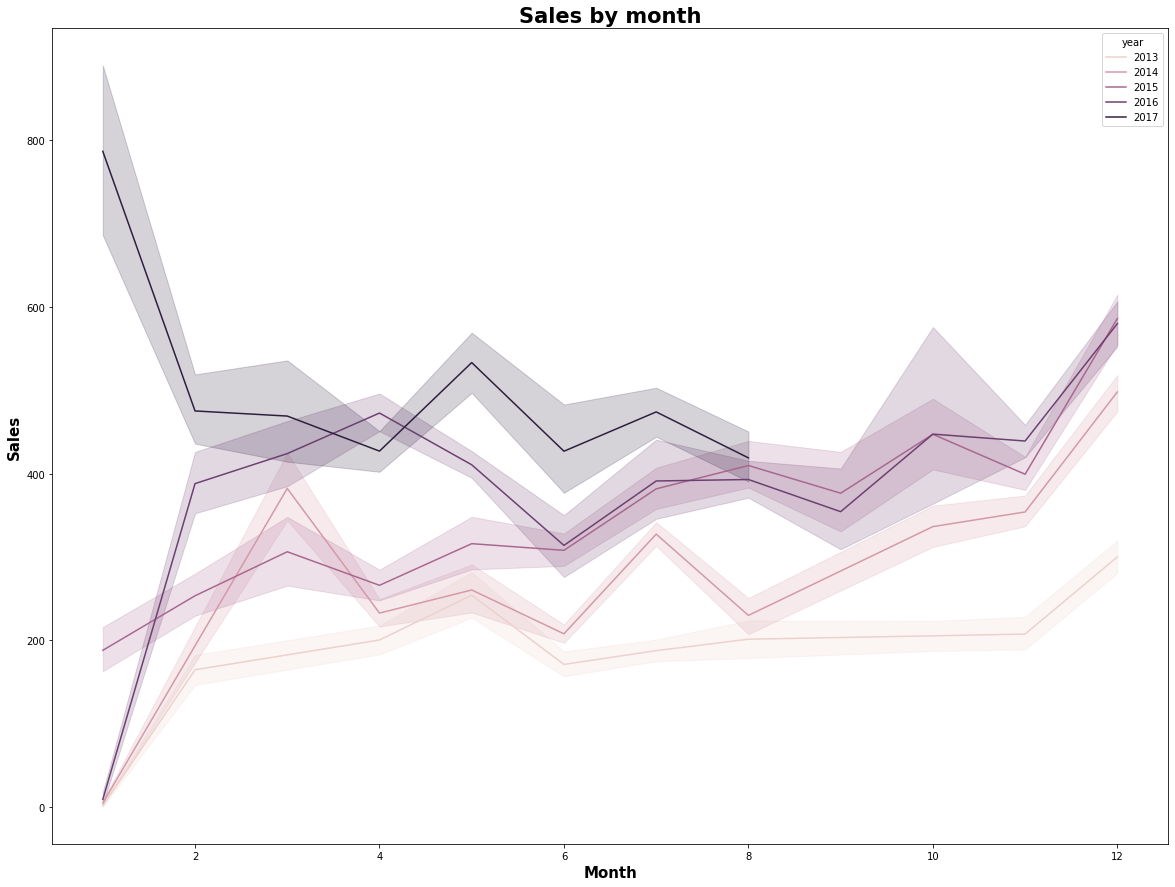

In [65]:
plt.figure(figsize=(20, 15)) 
sns.lineplot(train['month'], train['sales'], hue=train['year'])
plt.title('Sales by month', fontsize = 21, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Month', fontsize = 15, fontdict=dict(weight='bold'))
plt.ylabel('Sales', fontsize = 15, fontdict=dict(weight='bold'))
plt.show()

연-월 별로 분석해보자

In [70]:
year_month_df=pd.DataFrame(train.groupby('year-month').sum()['sales'])
year_month_df.head()

,sales
year-month,
2013-01,2.511619e+03
2013-02,5.874284e+05
2013-04,1.072007e+06
2013-05,9.063639e+05
2013-06,9.153586e+05


In [71]:
year_month_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 2013-01 to 2017-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   52 non-null     float64
dtypes: float64(1)
memory usage: 832.0+ bytes


[]

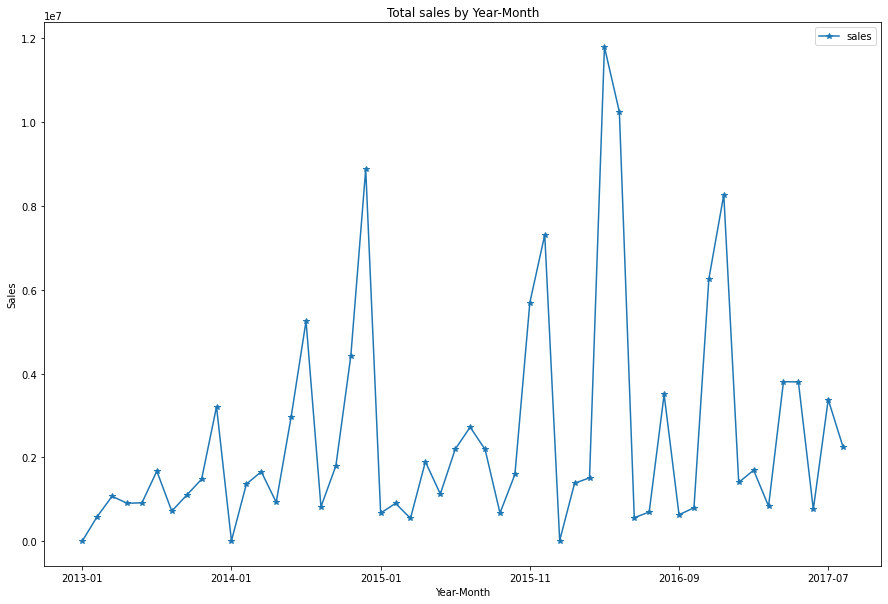

In [74]:
year_month_df.plot(kind='line',figsize=(15,10),marker='*')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.title('Total sales by Year-Month')
plt.plot()

연말에 판매량이 증가

시계열 groupby를 통해 multi-level index로 만들 필요성

rolling mean?